# Dataset 
Este notebook es el script module_pbashivan.py el cuál permite obtener el conjunto de datos de EEG que proponen en: https://github.com/pbashivan/EEGLearn/tree/master/Sample%20data


Basados en:

Bashivan, P., Rish, I., Yeasin, M., and Codella, N. (2016).
Learning representations from eeg with deep recurrent-convolutional neural networks.
In International Conference on Learning Representations (ICLR) 2016, pages 1–14.

In [1]:
import numpy as np
import scipy.io
import math as m
from scipy.interpolate import griddata
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import numpy as np
import random
import argparse
import warnings

warnings.simplefilter("ignore")


def load_data(data_file):
    """
    Loads the data from MAT file. MAT file should contain two
    variables. 'featMat' which contains the feature matrix in the
    shape of [samples, features] and 'labels' which contains the output
    labels as a vector. Label numbers are assumed to start from 1.

    Parameters
    ----------
    data_file: str

    Returns
    -------
    data: array_like
    """
    print("Loading data from %s" % (data_file))

    dataMat = scipy.io.loadmat(data_file, mat_dtype=True)
    all_data = np.array(dataMat['features'])
    
    data = np.array(all_data[:,:len(all_data[0])-1])
    labels = np.array(all_data[:,len(all_data[0])-1])
    
    print("Data loading complete. Shape is %r" % (dataMat['features'].shape,))
    
    return data, labels.T - 1   # Sequential indices


def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)


def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)


def augment_EEG(data, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param data: EEG feature data as a matrix (n_samples x n_features)
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros(data.shape)
    if pca:
        pca = PCA(n_components=n_components)
        pca.fit(data)
        components = pca.components_
        variances = pca.explained_variance_ratio_
        coeffs = np.random.normal(scale=stdMult, size=pca.n_components) * variances
        for s, sample in enumerate(data):
            augData[s, :] = sample + (components * coeffs.reshape((n_components, -1))).sum(axis=0)
    else:
        # Add Gaussian noise with std determined by weighted std of each feature
        for f, feat in enumerate(data.transpose()):
            augData[:, f] = feat + np.random.normal(scale=stdMult*np.std(feat), size=feat.size)
    return augData


def gen_images(locs, features, nGridPoints, normalize=True, n_bands=3,
               augment=False, pca=False, stdMult=0.1, n_components=2, edgeless=False, visualize=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    
    :param [loc]: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param [features]: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param [nGridPoints]: Number of pixels in the output images
    :param [normalize]:   Flag for whether to normalize each feature over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param stdMult:     Standard deviation of noise for augmentation
    :param n_components: Number of components in PCA to retain for augmentation
    :param [edgeless]:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """

    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes

    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    
    # division between columns and number of electrodes (floor)
    # 192 // 64 = 21
    n_colors = features.shape[1] // nElectrodes
    
    for c in range(n_colors):
        # Example:
        # c=0, nElectrodes= 64
        # [(c*nElec)=0 : (nElec*(c+1))=64]
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    
    # feat_array_temp must be 3 channels with alpha, beta, theta
    # feat_array_temp contains features in alpha beta, and theta for 3 colors
    # shape = [3, 2670, 64]
    #print("shape:",np.array(feat_array_temp).shape)

    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], stdMult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], stdMult, pca=False, n_components=n_components)
                print("augment!")
    
    # nSamples = 2670 (all samples)
    nSamples = features.shape[0]
    
    # Mesh (16x16 or 32x32) based on Min and Max locations
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):nGridPoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):nGridPoints*1j
                     ]
    
    if visualize:
        # Plot in interpolation 2D
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(grid_x, grid_y, c='r', marker='o')

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        
    
    # this part establishs array(21,2670,16,16) = zeros
    # (num_colors, num_samples, size, size)
    temp_interp = []
    for c in range(n_colors):
        a = np.zeros([nSamples, nGridPoints, nGridPoints])
        temp_interp.append(a)
        
    # Generate edgeless images 
    # It means that is not used formed of head but else use all area from image
    if edgeless:
        # min and max in image
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        # former a new array with points localizated in corners of image
        a = np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]])
        # add to original locations of EEG cap
        # locs now has 68 locations
        locs = np.append(locs, a, axis=0)

        # for each channel
        # add zeros in corners
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # end edgeless
    
    vis_interpolation = False
    # for each sample
    for i in range(nSamples):
        # for each channel or color
        for c in range(n_colors):
            # locs has 64 positions, feat_array_temp[c][i] has 64 corresponding values
            # interpolation for channel "c" and example "i"
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i], (grid_x, grid_y), method='cubic', fill_value=np.nan)
            
            # visualize example "i" in channel "c"
            if vis_interpolation:
                fig = plt.figure()
                plt.subplot(111)
                plt.imshow(temp_interp[c][i, :, :].T, extent=(0,1,0,1), origin='lower')
    
    vis_normalize = False
    #normalize data
    for c in range(n_colors):
        if normalize:
            # Center to the mean and component wise scale to unit variance.
            temp_interp[c][~np.isnan(temp_interp[c])] = scale(temp_interp[c][~np.isnan(temp_interp[c])])
        # Replace nan with zero and inf with finite numbers.
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    
        # visualize
        if vis_normalize:
            fig = plt.figure()
            plt.subplot(111)
            plt.imshow(temp_interp[c][0, :, :].T, extent=(0,1,0,1), origin='lower')
            plt.show()
    
    # Interchange two axes of an array.
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]



def split_losocv(X, y, indices):
    """
    Receives the the indices for train and test datasets.
    Outputs the train, validation, and test data and label datasets.
    """
    
    # get indices to train and test sets
    train_indices = indices[0]
    test_indices = indices[1]
    
    # obtains train and test sets 
    x_train = X[train_indices]
    y_train = np.squeeze(y[train_indices]).astype(np.int32)
    
    x_test = X[test_indices]
    y_test = np.squeeze(y[test_indices]).astype(np.int32)

    # get list of classes
    y_classes = np.unique(y_train)

    return [(x_train, y_train),
            (x_test, y_test),
            y_classes]


def split_losocv(X, y, indices):
    """
    Receives the the indices for train and test datasets.
    Outputs the train, validation, and test data and label datasets.
    """

    # get indices to train and test sets
    train_indices = indices[0]
    test_indices = indices[1]

    # obtains train and test sets
    x_train = X[train_indices]
    y_train = np.squeeze(y[train_indices]).astype(np.int32)

    x_test = X[test_indices]
    y_test = np.squeeze(y[test_indices]).astype(np.int32)

    # get list of classes
    y_classes = np.unique(y_train)

    return [(x_train, y_train),
            (x_test, y_test),
            y_classes]

def get_subject_data(X, y, indices):
    """
    Receives the the indices for train and test datasets.
    Outputs the train, validation, and test data and label datasets.
    """

    # get indices to train and test sets
    test_indices = indices[1]

    x_t = X[test_indices]
    y_t = np.squeeze(y[test_indices]).astype(np.int32)

    # get list of classes
    y_classes = np.unique(y_t)

    return [(x_t, y_t),
            y_classes]
    

    

def load_bashivan_data(data_dir, n_channels = 64, n_windows=7, n_bands=3, generate_images=False, size_image=32, visualize=False):
    
    """
        Module used to load dataset of bashivan et al. 2014.
    """
    
    # load data pbashivan
    data, labels = load_data(data_dir + "FeatureMat_timeWin.mat")
    print("Original data:",data.shape, labels.shape)
        
    if generate_images:
        
        # NOTE: Only a 3D projection is proporcionated, then it is not avaliable other
        # records with positions.
        
        #Load locations in 3D
        locs_orig = scipy.io.loadmat(data_dir+'Neuroscan_locs_orig.mat', mat_dtype=True)
        locs3D = locs_orig['A']
        
        #Convert to 2D
        locs2D =[]
        for e in locs3D:
            locs2D.append(azim_proj(e))
        
        #save in numpy array
        locs2D = np.array(locs2D)
        
        # visualize projection
        if visualize:
            print("No. channels:",locs3D.shape)
            
            # Plot in 3D
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(locs3D[:,0], locs3D[:,1], locs3D[:,2], c='b', marker='^')

            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            # Plot in 2D
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(locs2D[:,0], locs2D[:,1], c='b', marker='^')

            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            plt.show()
        
        # NOTE: database is defined with 7 time windows
        # FFT power values extracted for three frequency bands (theta, alpha, beta). 
        # Features are arranged in band and electrodes order (theta_1, theta_2..., 
        # theta_64, alpha_1, alpha_2, ..., beta_64). There are seven time windows, 
        # features for each time window are aggregated sequentially (i.e. 0:191 --> time window 1, 
        # 192:383 --> time windw 2 and so on. Last column contains the class labels (load levels).
        #generate images in time windows
        start = 0
        end = 0
        images = []
        for c in range(n_windows):
            # 0:191,192:383,... columns
            end = start + (n_channels * n_bands)
            print("Generating images from Time window ", (c+1))
            images.append(gen_images(locs2D, data[:,start:end], size_image, augment=False, pca=False, n_components=2))
            start = end

        #list ot array numpy
        images = np.array(images)
        # transpose
        images = images.transpose((1, 2, 0, 3, 4))
        scipy.io.savemat(data_dir+'images.mat', mdict={'images': images})
    
    else:
        #Load locations in 3D
        files_mat = scipy.io.loadmat(data_dir+'images.mat', mat_dtype=True)
        images = files_mat['images']
    
    #Load info subjects associated with trials. List of patiens for 2670 trials
    subjects_trials= scipy.io.loadmat(data_dir+'trials_subNums.mat', mat_dtype=True)
    subjNumbers = np.squeeze(subjects_trials['subjectNum'])
    
    
    print("Shape images", images.shape)
    
    return images, labels, subjNumbers

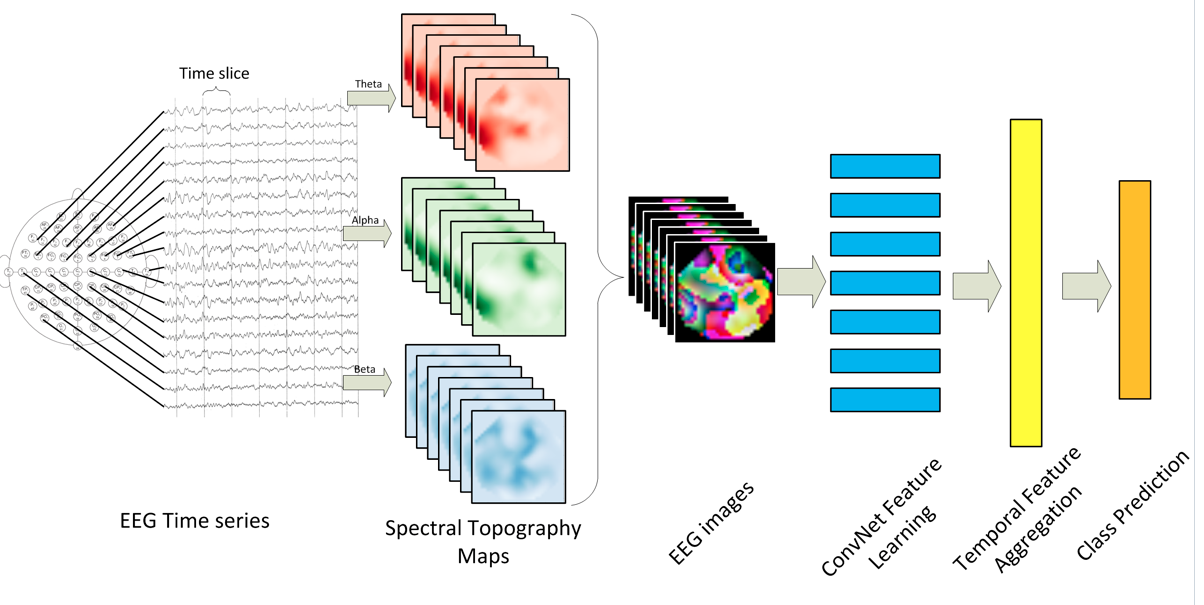

In [2]:
# Define path of Dataset
path = '/Dataset/'

In [3]:
# First time generate_images=True

In [4]:
# load data
X, Y, subjects = load_bashivan_data(path,
                        n_channels=64, n_windows=7, n_bands=3, generate_images=True,
                        size_image=24, visualize=False)

Loading data from /home/fer2696/Maestria/Taller Macroentrenamiento IA/Taller_Macroentrenamiento IA/Dataset/FeatureMat_timeWin.mat
Data loading complete. Shape is (2670, 1345)
Original data: (2670, 1344) (2670,)
Generating images from Time window  1
Generating images from Time window  2
Generating images from Time window  3
Generating images from Time window  4
Generating images from Time window  5
Generating images from Time window  6
Generating images from Time window  7
Shape images (2670, 3, 7, 24, 24)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


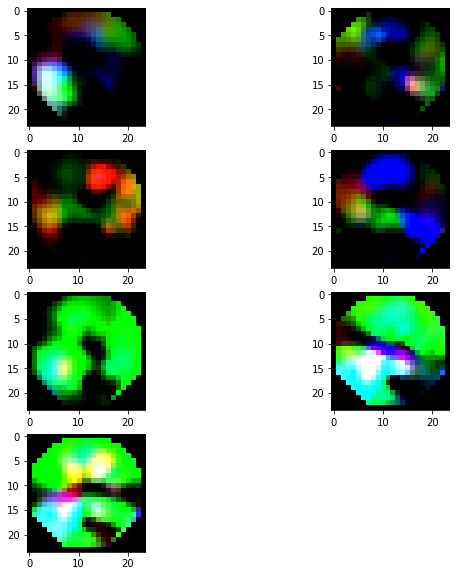

In [5]:
fig = plt.figure(figsize=(10, 10))
for i in range(7):
    fig.add_subplot(4, 2, i+1)
    img = X[500,:,i,:,:].T 
    plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


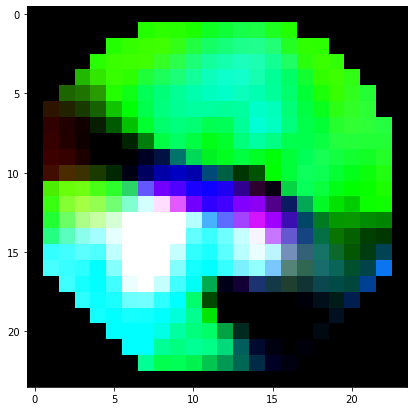

In [6]:
plt.figure(figsize=(7,7))
imgplot = plt.imshow((X[500,:,5,:,:].T))

In [7]:
Y

array([0., 0., 0., ..., 3., 3., 3.])

In [8]:
np.unique(Y)

array([0., 1., 2., 3.])

In [9]:
subjects

array([ 1.,  1.,  1., ..., 15., 15., 15.])

In [10]:
np.unique(subjects)

array([ 1.,  2.,  3.,  4.,  6.,  7.,  8.,  9., 10., 11., 12., 14., 15.])